In [1]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
import os

load_dotenv('pwd.env')

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv("DB_HOST")

In [3]:
from sqlalchemy import create_engine, text 

username = db_user
password = db_password
host = db_host
port = '5433'
database = 'companies_DWH'


connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("connection was successful!")
except Exception as e:
    print("connection failed:", e)

connection was successful!


In [4]:
import pandas as pd

companies_layoffs = pd.read_sql(
    '''
    SELECT * 
FROM information_schema.columns 
WHERE table_name = 'layoffs_companies';

    ''', engine
)

print(companies_layoffs)

    table_catalog table_schema         table_name  \
0   companies_DWH       public  layoffs_companies   
1   companies_DWH       public  layoffs_companies   
2   companies_DWH       public  layoffs_companies   
3   companies_DWH       public  layoffs_companies   
4   companies_DWH       public  layoffs_companies   
5   companies_DWH       public  layoffs_companies   
6   companies_DWH       public  layoffs_companies   
7   companies_DWH       public  layoffs_companies   
8   companies_DWH       public  layoffs_companies   
9   companies_DWH       public  layoffs_companies   
10  companies_DWH       public  layoffs_companies   
11  companies_DWH       public  layoffs_companies   
12  companies_DWH       public  layoffs_companies   
13  companies_DWH       public  layoffs_companies   
14  companies_DWH       public  layoffs_companies   

                    column_name  ordinal_position column_default is_nullable  \
0                     longitude                15           None       

In [5]:
import pandas as pd 
import numpy as np 

pd.set_option('display.expand_frame_repr', False)



companies_layoffs_sort = pd.read_sql(
    '''
    SELECT 
        "Company",
        SUM("Laid_Off") AS "Total_Laid_Off",
        MAX("Date_layoffs") AS "Latest_Layoff_Date"
    FROM public.layoffs_companies
    GROUP BY "Company"
    ORDER BY "Total_Laid_Off" DESC
    ''', engine
)

companies_total_emp = pd.read_sql(
    '''
    SELECT
    "name", "total employee estimate"
    FROM public."large_size_companies"
    WHERE "name" in ('amazon', 'facebook', 'microsoft', 'google', 'sap', 'tesla', 'ericsson', 'cisco', 'flink', 'uber')
    ORDER BY "total employee estimate"
''', engine
)

companies_layoff_sort = companies_layoffs_sort.sort_values(by = 'Total_Laid_Off', ascending = False)

top_10 = companies_layoff_sort.head(10)

print(top_10)


companies_total_emp = companies_total_emp.sort_values(by = "total employee estimate", ascending = False)

top = companies_total_emp.head(10)

print(top)

top_10['Company'] = top_10['Company'].str.lower()
top['name'] = top['name'].str.lower()


merged_df = pd.merge(top_10, top, left_on='Company', right_on='name', how='left')

merged_df['Percentage_Laid_Off'] = (merged_df['Total_Laid_Off'] / merged_df['total employee estimate']) * 100

merged_df['Percentage_Laid_Off'] = merged_df['Percentage_Laid_Off'].fillna(np.nan)

print(merged_df[['Company', 'Total_Laid_Off', 'Percentage_Laid_Off']])

     Company  Total_Laid_Off Latest_Layoff_Date
0     Amazon         55160.0         2024-04-03
1       Meta         42050.0         2024-06-12
2  Microsoft         27800.0         2024-06-04
3     Google         26557.0         2024-05-31
4        SAP         22000.0         2024-01-23
5      Tesla         20520.0         2024-04-30
6   Ericsson         17000.0         2023-02-24
7      Cisco         16700.0         2024-02-14
8      Flink         16200.0         2023-05-24
9       Uber         15450.0         2023-06-21
        name  total employee estimate
6  microsoft                   276983
5     amazon                   161866
4      cisco                   139423
3     google                   131349
2   facebook                    49059
1       uber                    36867
0      tesla                    20739
     Company  Total_Laid_Off  Percentage_Laid_Off
0     amazon         55160.0            34.077570
1       meta         42050.0                  NaN
2  microsoft      

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_8976\2737320777.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Company'] = top_10['Company'].str.lower()


In [6]:
layoffs_locations = pd.read_sql(
    '''
    SELECT
        "Location_HQ",
        SUM("Laid_Off") AS "Total_Laid_Off"
    FROM public.layoffs_companies
    GROUP BY "Location_HQ"
    ORDER BY "Total_Laid_Off" DESC
''', engine
)

layoffs_locations = layoffs_locations.sort_values(by = "Total_Laid_Off", ascending = False)

top_10 = layoffs_locations.head(10)

top_10

,Location_HQ,Total_Laid_Off
0,San Francisco Bay Area,153693.0
1,Seattle,102406.0
2,San Francisco,75507.0
3,New York City,54532.0
4,Bengaluru,40380.0
5,Austin,35054.0
6,London,29102.0
7,Boston,27857.0
8,Menlo Park,26202.0
9,Stockholm,25030.0


In [7]:
type(top_10)

pandas.core.frame.DataFrame

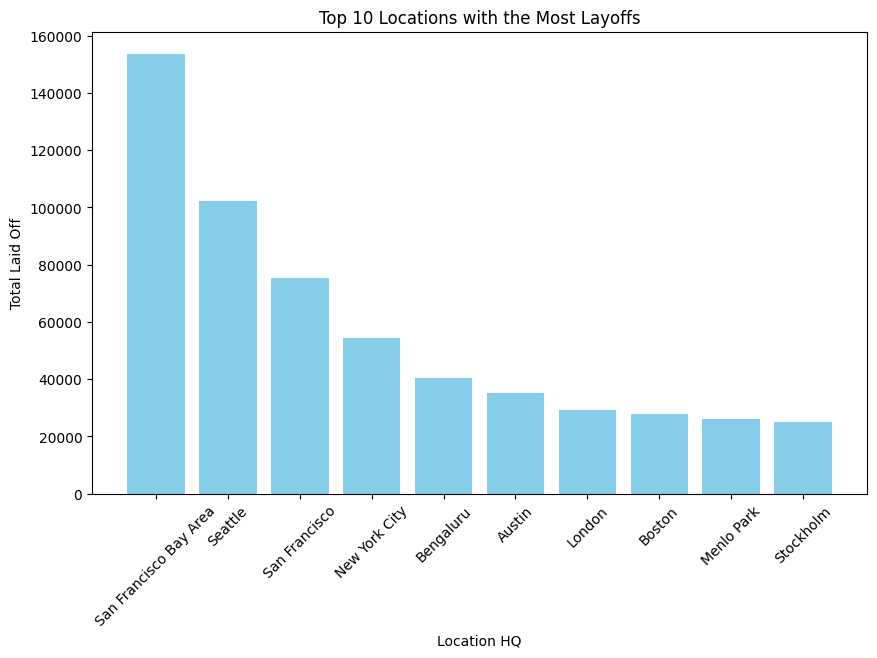

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_10['Location_HQ'], top_10['Total_Laid_Off'], color='skyblue')
plt.xlabel('Location HQ')
plt.ylabel('Total Laid Off')
plt.title('Top 10 Locations with the Most Layoffs')
plt.xticks(rotation=45)
plt.show()